In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib



In [ ]:
df = pd.read_excel("hotel_reviews (2).xlsx")

# Display the first few rows of the dataset to understand its structure
print(df.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
 import nltk
 nltk.download('stopwords')
 nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

# Function for text cleaning and preprocessing
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Remove stopwords
    stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

# Apply the cleaning function to the 'Review' column
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Display the first few rows of the cleaned dataset
print(df.head())

                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      Cleaned_Review  
0  nice hotel expensive parking got good deal sta...  
1  ok special charge diamond member hilton decide...  
2  nice room experience hotel monaco seattle good...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went seahawk game awesom...  


                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      Cleaned_Review  Polarity  Subjectivity  \
0  nice hotel expensive parking got good deal sta...  0.208744      0.687000   
1  ok special charge diamond member hilton decide...  0.214923      0.495009   
2  nice room experience hotel monaco seattle good...  0.294420      0.605208   
3  unique great stay wonderful time hotel monaco ...  0.504825      0.691228   
4  great stay great stay went seahawk game awesom...  0.384615      0.629396   

  Sentiment_Label_Rating  
0               positive  
1               negative  
2                neutral  
3               positive  

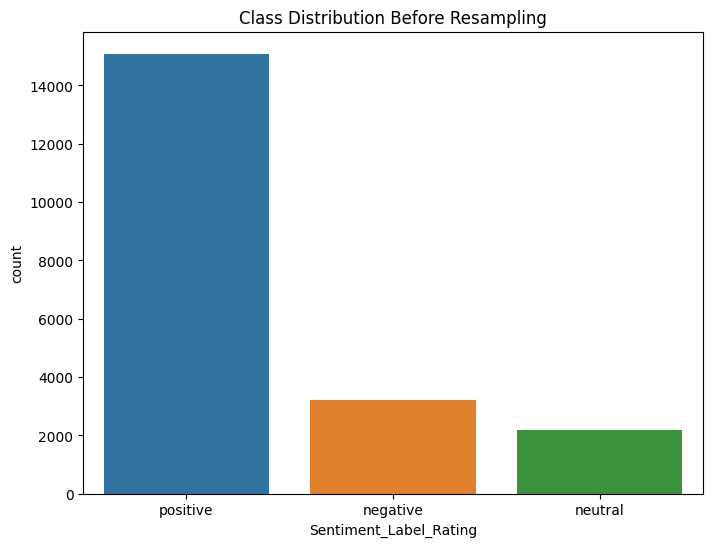

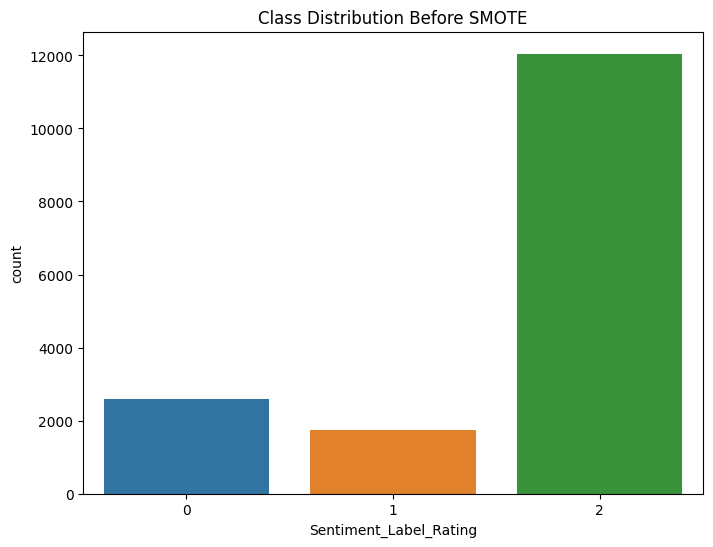

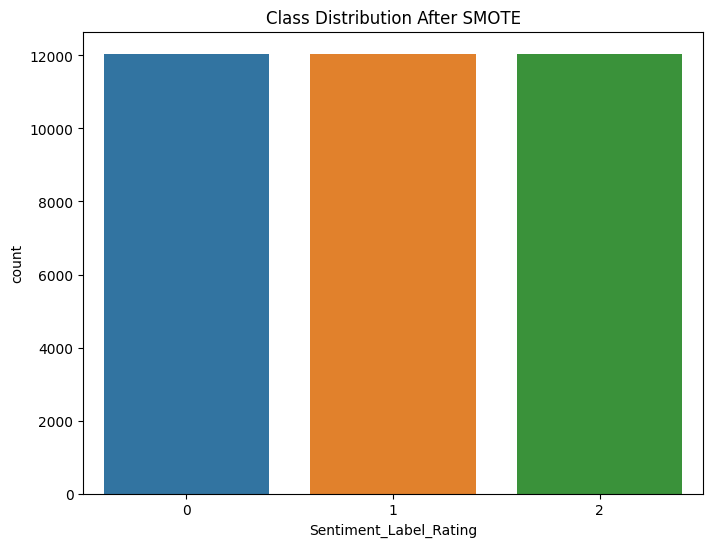

In [ ]:
# Function to calculate polarity and subjectivity
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Function to categorize sentiment based on ratings
def categorize_sentiment_by_rating(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'
    else:
        return 'undefined'  # Handle undefined cases

# Apply the sentiment analysis and categorization functions
df['Polarity'], df['Subjectivity'] = zip(*df['Review'].apply(analyze_sentiment))
df['Sentiment_Label_Rating'] = df['Rating'].apply(categorize_sentiment_by_rating)

# Display the first few rows of the updated dataset
print(df.head())

# Display the distribution of classes in the target variable before resampling
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_Label_Rating', data=df)
plt.title('Class Distribution Before Resampling')
plt.show()

# Encoding the target variable
le = LabelEncoder()
df['Sentiment_Label_Rating'] = le.fit_transform(df['Sentiment_Label_Rating'])

# Assuming you have not yet performed TF-IDF
X = df['Review']  # Use 'Review' column here
y = df['Sentiment_Label_Rating']

# Display the class distribution before resampling
print("Class distribution before resampling:")
print(y.value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply TF-IDF on the training set
tfidf_vectorizer = TfidfVectorizer(max_features=50000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Display the class distribution before SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.show()

# Apply SMOTE for oversampling the minority class on the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Display the class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()



In [ ]:
# Train a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred = logreg_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Accuracy: 0.8353

Confusion Matrix:
[[ 493  100   32]
 [ 105  205  122]
 [  63  253 2726]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       625
           1       0.37      0.47      0.41       432
           2       0.95      0.90      0.92      3042

    accuracy                           0.84      4099
   macro avg       0.69      0.72      0.70      4099
weighted avg       0.85      0.84      0.84      4099



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Train a Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

# Display the results for Multinomial Naive Bayes
print("Multinomial Naive Bayes Model:")
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_nb)
print("\nClassification Report:")
print(classification_rep_nb)


Multinomial Naive Bayes Model:
Accuracy: 0.7458

Confusion Matrix:
[[ 470  137   18]
 [ 108  259   65]
 [ 145  569 2328]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       625
           1       0.27      0.60      0.37       432
           2       0.97      0.77      0.85      3042

    accuracy                           0.75      4099
   macro avg       0.63      0.71      0.64      4099
weighted avg       0.84      0.75      0.78      4099



In [ ]:
# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred_dt = dt_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

# Display the results for Decision Tree
print("Decision Tree Model:")
print(f"Accuracy: {accuracy_dt:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_dt)
print("\nClassification Report:")
print(classification_rep_dt)


Decision Tree Model:
Accuracy: 0.6897

Confusion Matrix:
[[ 339  118  168]
 [ 105  127  200]
 [ 282  399 2361]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       625
           1       0.20      0.29      0.24       432
           2       0.87      0.78      0.82      3042

    accuracy                           0.69      4099
   macro avg       0.51      0.54      0.52      4099
weighted avg       0.73      0.69      0.71      4099



In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Display the results for Random Forest
print("Random Forest Model:")
print(f"Accuracy: {accuracy_rf:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf)
print("\nClassification Report:")
print(classification_rep_rf)


Random Forest Model:
Accuracy: 0.8000

Confusion Matrix:
[[ 354    8  263]
 [  60   29  343]
 [  81   65 2896]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63       625
           1       0.28      0.07      0.11       432
           2       0.83      0.95      0.89      3042

    accuracy                           0.80      4099
   macro avg       0.61      0.53      0.54      4099
weighted avg       0.75      0.80      0.76      4099



In [ ]:
# Train an XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Display the results for XGBoost
print("XGBoost Model:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_xgb)
print("\nClassification Report:")
print(classification_rep_xgb)


XGBoost Model:
Accuracy: 0.8373

Confusion Matrix:
[[ 471   55   99]
 [  99  114  219]
 [  50  145 2847]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       625
           1       0.36      0.26      0.31       432
           2       0.90      0.94      0.92      3042

    accuracy                           0.84      4099
   macro avg       0.67      0.65      0.66      4099
weighted avg       0.82      0.84      0.83      4099



In [ ]:
#Lets predict a sentence

In [ ]:
# Example sentence to predict
example_sentence = "This hotel exceeded my expectations. The staff was friendly and the room was clean."

# Clean and preprocess the example sentence (assuming you have a clean_text function)
cleaned_example = clean_text(example_sentence)

# Transform the cleaned example sentence using TF-IDF vectorizer
example_tfidf = tfidf_vectorizer.transform([cleaned_example])

# Predict sentiment using the trained XGBoost model
predicted_sentiment = xgb_model.predict(example_tfidf)[0]

# Decode the predicted sentiment label if you used LabelEncoder
decoded_sentiment = le.inverse_transform([predicted_sentiment])[0]

# Display the result
print(f"Predicted Sentiment: {decoded_sentiment}")


Predicted Sentiment: positive


In [ ]:
#Hypertuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Define the hyperparameters to tune
# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['lbfgs', 'liblinear'],  # Optimization algorithm
    'class_weight': [None, {0: 1, 1: 2, 2: 1}]  # Class weights
}

# Create GridSearchCV
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Display the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Get the best model
best_logreg_model = grid_search.best_estimator_

# Predictions on the test set using the best model
y_pred = best_logreg_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters:
{'C': 100, 'class_weight': None, 'solver': 'liblinear'}

Accuracy: 0.8380

Confusion Matrix:
[[ 479   85   61]
 [ 107  148  177]
 [  58  176 2808]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       625
           1       0.36      0.34      0.35       432
           2       0.92      0.92      0.92      3042

    accuracy                           0.84      4099
   macro avg       0.68      0.68      0.68      4099
weighted avg       0.84      0.84      0.84      4099



In [ ]:
from sklearn.linear_model import LogisticRegression

# Final Logistic Regression model with best parameters
final_logreg_model = LogisticRegression(C=100, solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)

# Train the final model on the resampled data
final_logreg_model.fit(X_resampled, y_resampled)

# Predictions on the test set
final_y_pred = final_logreg_model.predict(X_test_tfidf)

# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_y_pred)
final_conf_matrix = confusion_matrix(y_test, final_y_pred)
final_classification_rep = classification_report(y_test, final_y_pred)

# Display the results for the final model
print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("\nFinal Model Confusion Matrix:")
print(final_conf_matrix)
print("\nFinal Model Classification Report:")
print(final_classification_rep)


Final Model Accuracy: 0.8380

Final Model Confusion Matrix:
[[ 479   85   61]
 [ 107  148  177]
 [  58  176 2808]]

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       625
           1       0.36      0.34      0.35       432
           2       0.92      0.92      0.92      3042

    accuracy                           0.84      4099
   macro avg       0.68      0.68      0.68      4099
weighted avg       0.84      0.84      0.84      4099



In [ ]:
# Example sentence to predict
example_sentence = "Hotel service okay"
# Clean and preprocess the example sentence (assuming you have a clean_text function)
cleaned_example = clean_text(example_sentence)

# Transform the cleaned example sentence using TF-IDF vectorizer
example_tfidf = tfidf_vectorizer.transform([cleaned_example])

# Predict sentiment using the trained XGBoost model
predicted_sentiment = final_logreg_model.predict(example_tfidf)[0]

# Decode the predicted sentiment label if you used LabelEncoder
decoded_sentiment = le.inverse_transform([predicted_sentiment])[0]

# Display the result
print(f"Predicted Sentiment: {decoded_sentiment}")

In [ ]:
# Train the final model on the resampled data
final_logreg_model.fit(X_resampled, y_resampled)

# Save TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# Save the trained Logistic Regression model
joblib.dump(final_logreg_model, 'final_logreg_model.joblib')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder.joblib')

# Predictions on the test set
final_y_pred = final_logreg_model.predict(X_test_tfidf)

# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_y_pred)
final_conf_matrix = confusion_matrix(y_test, final_y_pred)
final_classification_rep = classification_report(y_test, final_y_pred)

# Display the results for the final model
print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("\nFinal Model Confusion Matrix:")
print(final_conf_matrix)
print("\nFinal Model Classification Report:")
print(final_classification_rep)


Final Model Accuracy: 0.8380

Final Model Confusion Matrix:
[[ 479   85   61]
 [ 107  148  177]
 [  58  176 2808]]

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       625
           1       0.36      0.34      0.35       432
           2       0.92      0.92      0.92      3042

    accuracy                           0.84      4099
   macro avg       0.68      0.68      0.68      4099
weighted avg       0.84      0.84      0.84      4099



In [ ]:
#Deployment

In [ ]:
# Save the XGBoost model
joblib.dump(final_logreg_model, 'final_logreg_model.joblib')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']